In [1]:
!pip install tabpfn --no-index --find-links=file:////kaggle/input/tabpfn-019-whl
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file://kaggle/input/tabpfn-019-whl
Processing /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl


In [2]:
import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNClassifier
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Define file paths
train_file_path = "/kaggle/input/icr-identify-age-related-conditions/train.csv"
test_file_path = "/kaggle/input/icr-identify-age-related-conditions/test.csv"
greeks_file_path = "/kaggle/input/icr-identify-age-related-conditions/greeks.csv"

# Load the data
train_df = pd.read_csv(train_file_path)
greeks_df = pd.read_csv(greeks_file_path)
test_df = pd.read_csv(test_file_path)
merged_df = pd.merge(train_df, greeks_df, on='Id')

In [4]:
def show_distribution(train_df, greeks_df):
    # Separate the merged dataframe by Class
    class_0_df = merged_df[merged_df['Class'] == 0]
    class_1_df = merged_df[merged_df['Class'] == 1]

    # Plot the distribution of each column separately for Class 0 and 1
    for col in merged_df.columns:
        if col not in ['Id', 'Class']:
            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.title(f"Distribution of {col} (Class 0)")
            sns.histplot(class_0_df[col], kde=False, bins=30)

            plt.subplot(1, 2, 2)
            plt.title(f"Distribution of {col} (Class 1)")
            sns.histplot(class_1_df[col], kde=False, bins=30)

            plt.tight_layout()
            plt.show()

# show_distribution(train_df, greeks_df)

In [5]:
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

In [6]:
le = LabelEncoder()

def create_feature(raw_data):
    res = raw_data.drop(columns=['Id'])
    res['EJ'] = le.fit_transform(res['EJ'])

    # 各カラムの99%タイルを取得
    percentile_01 = res.quantile(0.01)
    percentile_99 = res.quantile(0.99)

    # 各カラムをそれぞれの99%タイルでクリッピング
    for col in res.columns:
        if col == 'EJ':
            continue
        res[col] = res[col].clip(lower=percentile_01[col], upper=percentile_99[col])

    # 欠損値の有無を示すカラムの追加
    for column in ['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL']:
        res[column + '_missing'] = res[column].isnull().astype(int)

    # 欠損値を中央値で埋める
    res.fillna(res.median(), inplace=True)

    # 特徴量の掛け合わせ
    # columns_to_multiply = [col for col in res.columns if col not in ['Id', 'EJ', 'Class'] and not col.endswith('_missing')]
    # for i in range(len(columns_to_multiply)):
    #     for j in range(i + 1, len(columns_to_multiply)):
    #         col1 = columns_to_multiply[i]
    #         col2 = columns_to_multiply[j]
    #         res[col1 + '_x_' + col2] = res[col1] * res[col2]
    #         res = res.copy()

    # 特徴量の掛け合わせのうち影響度の大きかったもの
    for (col1, col2) in [('AB', 'EL'), ('BQ', 'DY'), ('DU', 'FR'), ('DU', 'FL'), ('AB', 'GL'), ('CR', 'DL'), ('AY', 'DL'), ('BC', 'DU'), ('AB', 'AF'), ('BP', 'DU'), ('CR', 'DH'), ('CR', 'CS'), ('CD ', 'GL'), ('DA', 'EE'), ('BQ', 'BZ'), ('DE', 'EE'), ('CR', 'DA'), ('BQ', 'DF'), ('DF', 'GL'), ('BQ', 'DI'), ('CC', 'DA'), ('DI', 'DU'), ('CC', 'EP'), ('AX', 'GL'), ('CC', 'CR'), ('BQ', 'FE'), ('DA', 'DE'), ('BQ', 'GH'), ('BN', 'EB'), ('CC', 'CH'), ('DF', 'FR'), ('CH', 'DA'), 
                         ('DL', 'EE'), ('EE', 'EP'), ('AF', 'AR'), ('BQ', 'DV'), ('AB', 'BQ'), ('EG', 'EP'), ('AB', 'BZ'), ('BQ', 'EL'), ('AB', 'FE'), ('CU', 'DE'), ('DE', 'DU'), ('DE', 'FR'), ('DU', 'FE'), ('CD ', 'DV'), ('CC', 'FI'), ('CD ', 'EL'), ('CD ', 'GH'), ('DE', 'FS'), ('DV', 'FR'), ('DH', 'EG'), ('AB', 'DI'), ('AB', 'CD '), ('BC', 'DY'), ('CR', 'FI'), ('DL', 'EP'), ('AR', 'CC'), ('CD ', 'FE'), ('CH', 'FI'), ('AB', 'EB'), ('AF', 'EL'), ('AX', 'EG'), ('DU', 'GH'), ('BC', 'FL'), ('AF', 'CD '), ('CC', 'DE'), ('CH', 'CR'), ('AB', 'BC'), ('AF', 'AY'), ('BR', 'DU'), ('FL', 'FR'), ('AF', 'BD '), ('CB', 'DU')
                        ]:
        res[col1 + '_x_' + col2] = res[col1] * res[col2]
        res = res.copy()

    return res

In [7]:
def append_time(X, test_X):
    times = merged_df.Epsilon.copy()
    times[merged_df.Epsilon != 'Unknown'] = merged_df.Epsilon[merged_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
    times_missing = times.isnull().astype(int)
    times[merged_df.Epsilon == 'Unknown'] = np.nan
    times.fillna(times.median(), inplace=True)
    X['Times'] = times
    X['Times_missing'] = times_missing
    test_X['Times'] = times.max() + 1
    test_X['Times_missing'] = 0

In [8]:
def run_xgboost_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params):
    dtrain = xgb.DMatrix(train_data_x, label=train_data_y)
    evals_result = None
    if validate_data_x is not None:
        dval = xgb.DMatrix(validate_data_x, label=validate_data_y)
        evals_result = {}
        model = xgb.train(params, dtrain, num_boost_round=1000, 
                          evals=[(dtrain, 'train'), (dval, 'eval')],
                          early_stopping_rounds=10, verbose_eval=False,
                          evals_result=evals_result)
    else:
        model = xgb.train(params, dtrain, num_boost_round=1000,
                          early_stopping_rounds=10, verbose_eval=False)

    return (
        model.predict(xgb.DMatrix(validate_data_x)) if validate_data_x is not None else None,
        model.predict(xgb.DMatrix(test_data_x)) if test_data_x is not None else None,
        evals_result
    )

In [9]:
def run_xgboost_01(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'min_child_weight': 2.038692564884179,
        'learning_rate': 0.016618780117074988,
        'subsample': 0.5307842880619659,
        'gamma': 0.3457097567614843,
        'colsample_bytree': 0.8333363142738628,
        'colsample_bylevel': 0.8647839269706451,
        'colsample_bynode': 0.9406556418907105
    }
    return run_xgboost_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params)

In [10]:
def run_xgboost_02(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 5,
        'min_child_weight': 2.989776121887716,
        'learning_rate': 0.028885346146120892,
        'subsample': 0.5241321720387728,
        'gamma': 0.45860132988072233,
        'colsample_bytree': 0.835776390612672,
        'colsample_bylevel': 0.8873190500479705,
        'colsample_bynode': 0.802037773728281
    }
    return run_xgboost_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params)

In [11]:
def run_catboost_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params):
    train_pool = catboost.Pool(train_data_x, label=train_data_y)
    evals_result = None
    
    if validate_data_x is not None:
        validate_pool = catboost.Pool(validate_data_x, label=validate_data_y)
        model = catboost.CatBoostClassifier(iterations=1000, **params)
        model.fit(train_pool, eval_set=validate_pool, early_stopping_rounds=10, verbose=False)
        evals_result = model.get_evals_result()
    else:
        model = catboost.CatBoostClassifier(iterations=1000, **params)
        model.fit(train_pool, early_stopping_rounds=10, verbose=False)

    return (
        model.predict_proba(validate_data_x)[:,1] if validate_data_x is not None else None,
        model.predict_proba(test_data_x)[:,1] if test_data_x is not None else None,
        evals_result
    )

In [12]:
def run_catboost_01(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    params = {
        'loss_function': 'Logloss',
        'depth': 5,
        'l2_leaf_reg': 2.989776121887716,
        'learning_rate': 0.028885346146120892,
        'subsample': 0.5241321720387728,
        'random_strength': 0.45860132988072233,
        'rsm': 0.835776390612672,
        'bootstrap_type': 'Bernoulli'
    }
    return run_catboost_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params)

In [13]:
def run_catboost_02(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    params = {
        'loss_function': 'Logloss',
        'depth': 4,
        'l2_leaf_reg': 58.37764018018811,
        'learning_rate': 0.04293131747315081,
        'subsample': 0.41366305089647437,
        'random_strength': 0.708423265544224,
        'rsm': 0.20333075448560559,
        'bootstrap_type': 'Bernoulli'
    }
    return run_catboost_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params)

In [14]:
def run_catboost_03(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    params = {
        'loss_function': 'Logloss',
        'depth': 5,
        'l2_leaf_reg': 31.600508002692745,
        'learning_rate': 0.03296631800326877,
        'subsample': 0.3451091619275299,
        'random_strength': 0.5006234899661085,
        'rsm': 0.2025971289187097,
        'bootstrap_type': 'Bernoulli'
    }
    return run_catboost_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params)

In [15]:
def run_lightgbm_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params):
    dtrain = lgb.Dataset(train_data_x, label=train_data_y)
    evals_result = {}
    if validate_data_x is not None:
        dval = lgb.Dataset(validate_data_x, label=validate_data_y)
        callbacks = [
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=1000, show_stdv=False),
            lgb.record_evaluation(evals_result)
        ]
        model = lgb.train(params, dtrain, num_boost_round=1000,
                          valid_sets=[dtrain, dval],
                         callbacks=callbacks)
    else:
        callbacks = [
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=1),
        ]
        model = lgb.train(params, dtrain, num_boost_round=1000,
                          callbacks=callbacks)

    return (
        model.predict(validate_data_x) if validate_data_x is not None else None,
        model.predict(test_data_x) if test_data_x is not None else None,
        evals_result
    )

In [16]:
def run_lightgbm_01(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    params = {
        'verbosity': -1,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': 5,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
    }
    return run_lightgbm_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params)

In [17]:
def run_lightgbm_02(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    params = {
        'verbosity': -1,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': 8,
        'learning_rate': 0.04777749847992549,
        'feature_fraction': 0.21789717769793313,
        'bagging_fraction': 0.2185340460219071
    }
    return run_lightgbm_impl(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, params)


In [18]:
def run_tabpfn(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, emsemble_num):
    tabpfn = TabPFNClassifier(N_ensemble_configurations=emsemble_num)
    tabpfn.fit(train_data_x.head(1024), train_data_y.head(1024), overwrite_warning=True)
    return (
        tabpfn.predict_proba(validate_data_x)[:,1] if validate_data_x is not None else None,
        tabpfn.predict_proba(test_data_x)[:,1] if test_data_x is not None else None,
        None
    )

In [19]:
def run_tabpfn_16(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    return run_tabpfn(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, 16)

In [20]:
def run_tabpfn_64(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x):
    return run_tabpfn(train_data_x, train_data_y, validate_data_x, validate_data_y, test_data_x, 64)

In [21]:
def run_optuna_cat():
    X = create_feature(train_df)
    y = train_df['Class']

    # KFoldクロスバリデーション
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        res = []
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            X_train_raw, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train_raw, y_val = y.iloc[train_index], y.iloc[val_index]

            ros = RandomOverSampler(random_state=42)

            # X_train, y_train = ros.fit_resample(X_train_raw, y_train_raw)
            X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Alpha'])
            y_train = (y_train != 'A').astype(int)
            # X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Gamma'])
            # y_train = (~(y_train.isin(['N', 'M']))).astype(int)

            X_train = X_train.drop(columns=['Class'])
            X_val = X_val.drop(columns=['Class'])

            params = {
                'loss_function': 'Logloss',
                'depth': trial.suggest_int('depth', 3, 8),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 310),
                'learning_rate':  trial.suggest_float('learning_rate', 0.01, 0.05),
                'subsample': trial.suggest_float('subsample', 0.2, 1),
                'random_strength': trial.suggest_float('random_strength', 0.2, 1),
                'rsm': trial.suggest_float('rsm', 0.2, 1),
                'bootstrap_type': 'Bernoulli',
            }
            res.append(balanced_log_loss(y_val, run_catboost_impl(X_train, y_train, None, None, X_val, params)[1]))

        return sum(res)

    study = optuna.create_study(study_name='cat-study-alpha',
                                storage='sqlite:///cat_study_alpha.db',
                                load_if_exists=True,
                                direction='minimize')
    study.optimize(objective, n_trials=100, timeout=3600)

# run_optuna_cat()

In [22]:
def run_optuna_xgb():
    X = create_feature(train_df)
    y = train_df['Class']

    # KFoldクロスバリデーション
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        res = []
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            X_train_raw, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train_raw, y_val = y.iloc[train_index], y.iloc[val_index]

            ros = RandomOverSampler(random_state=42)

            # X_train, y_train = ros.fit_resample(X_train_raw, y_train_raw)
            X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Alpha'])
            y_train = (y_train != 'A').astype(int)
            # X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Gamma'])
            # y_train = (~(y_train.isin(['N', 'M']))).astype(int)

            X_train = X_train.drop(columns=['Class'])
            X_val = X_val.drop(columns=['Class'])

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            evals_result = {}
            # パラメータの設定
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'min_child_weight': trial.suggest_float('min_child_weight', 2, 310),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05), 
                'subsample': trial.suggest_float('subsample', 0.5, 1),
                'gamma': trial.suggest_float("gamma", 0.1, 0.5), 
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1), 
                'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1),  
                'colsample_bynode': trial.suggest_float('colsample_bynode', 0.2, 1)
            }

            model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtrain, 'train'), (dval, 'eval')],
                              early_stopping_rounds=10, verbose_eval=False, evals_result=evals_result)
            eval_prod = model.predict(xgb.DMatrix(X_val))
            res.append(balanced_log_loss(y_val, eval_prod))
        return sum(res)

    study = optuna.create_study(study_name='xgb-study-alpha',
                                storage='sqlite:///xgb_study_alpha.db',
                                load_if_exists=True,
                                direction='minimize')
    study.optimize(objective, n_trials=100, timeout=3600)

# run_optuna_xgb()

In [23]:
def run_optuna_lgt():
    X = create_feature(train_df)
    y = train_df['Class']

    # KFoldクロスバリデーション
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        res = []
        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            X_train_raw, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train_raw, y_val = y.iloc[train_index], y.iloc[val_index]

            ros = RandomOverSampler(random_state=42)

            # X_train, y_train = ros.fit_resample(X_train_raw, y_train_raw)
            X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Alpha'])
            y_train = (y_train != 'A').astype(int)
            # X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Gamma'])
            # y_train = (~(y_train.isin(['N', 'M']))).astype(int)

            X_train = X_train.drop(columns=['Class'])
            X_val = X_val.drop(columns=['Class'])
            params = {
                'verbosity': -1,
                'objective': 'binary',
                'metric': 'binary_logloss',
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 1),
                'bagging_freq': trial.suggest_int('max_depth', 3, 8),
            }
            res.append(balanced_log_loss(y_val, run_lightgbm_impl(X_train, y_train, X_val, y_val, X_val, params)[1]))

        return sum(res)

    study = optuna.create_study(study_name='lgt-study-alpha',
                                storage='sqlite:///lgt_study_alpha.db',
                                load_if_exists=True,
                                direction='minimize')
    study.optimize(objective, n_trials=1000, timeout=36000)

#run_optuna_lgt()

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00135275	valid_1's binary_logloss: 0.0811712


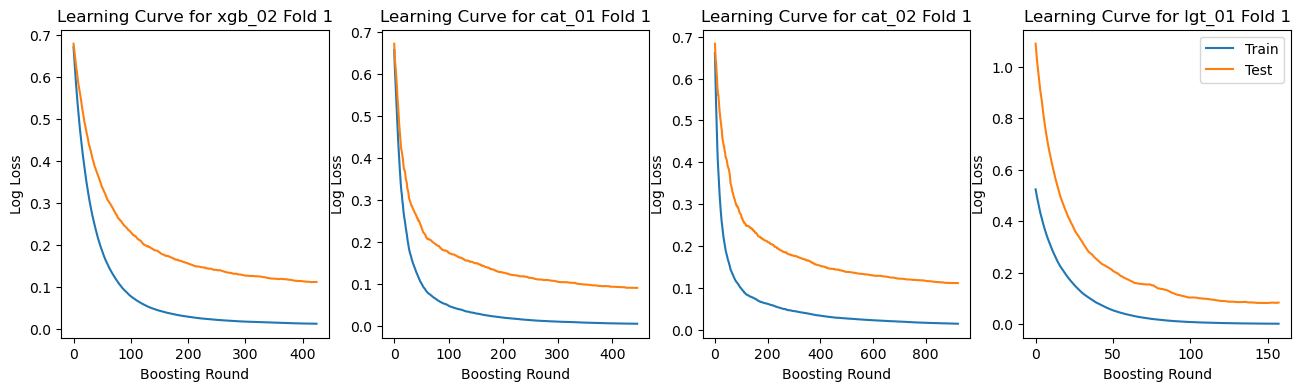

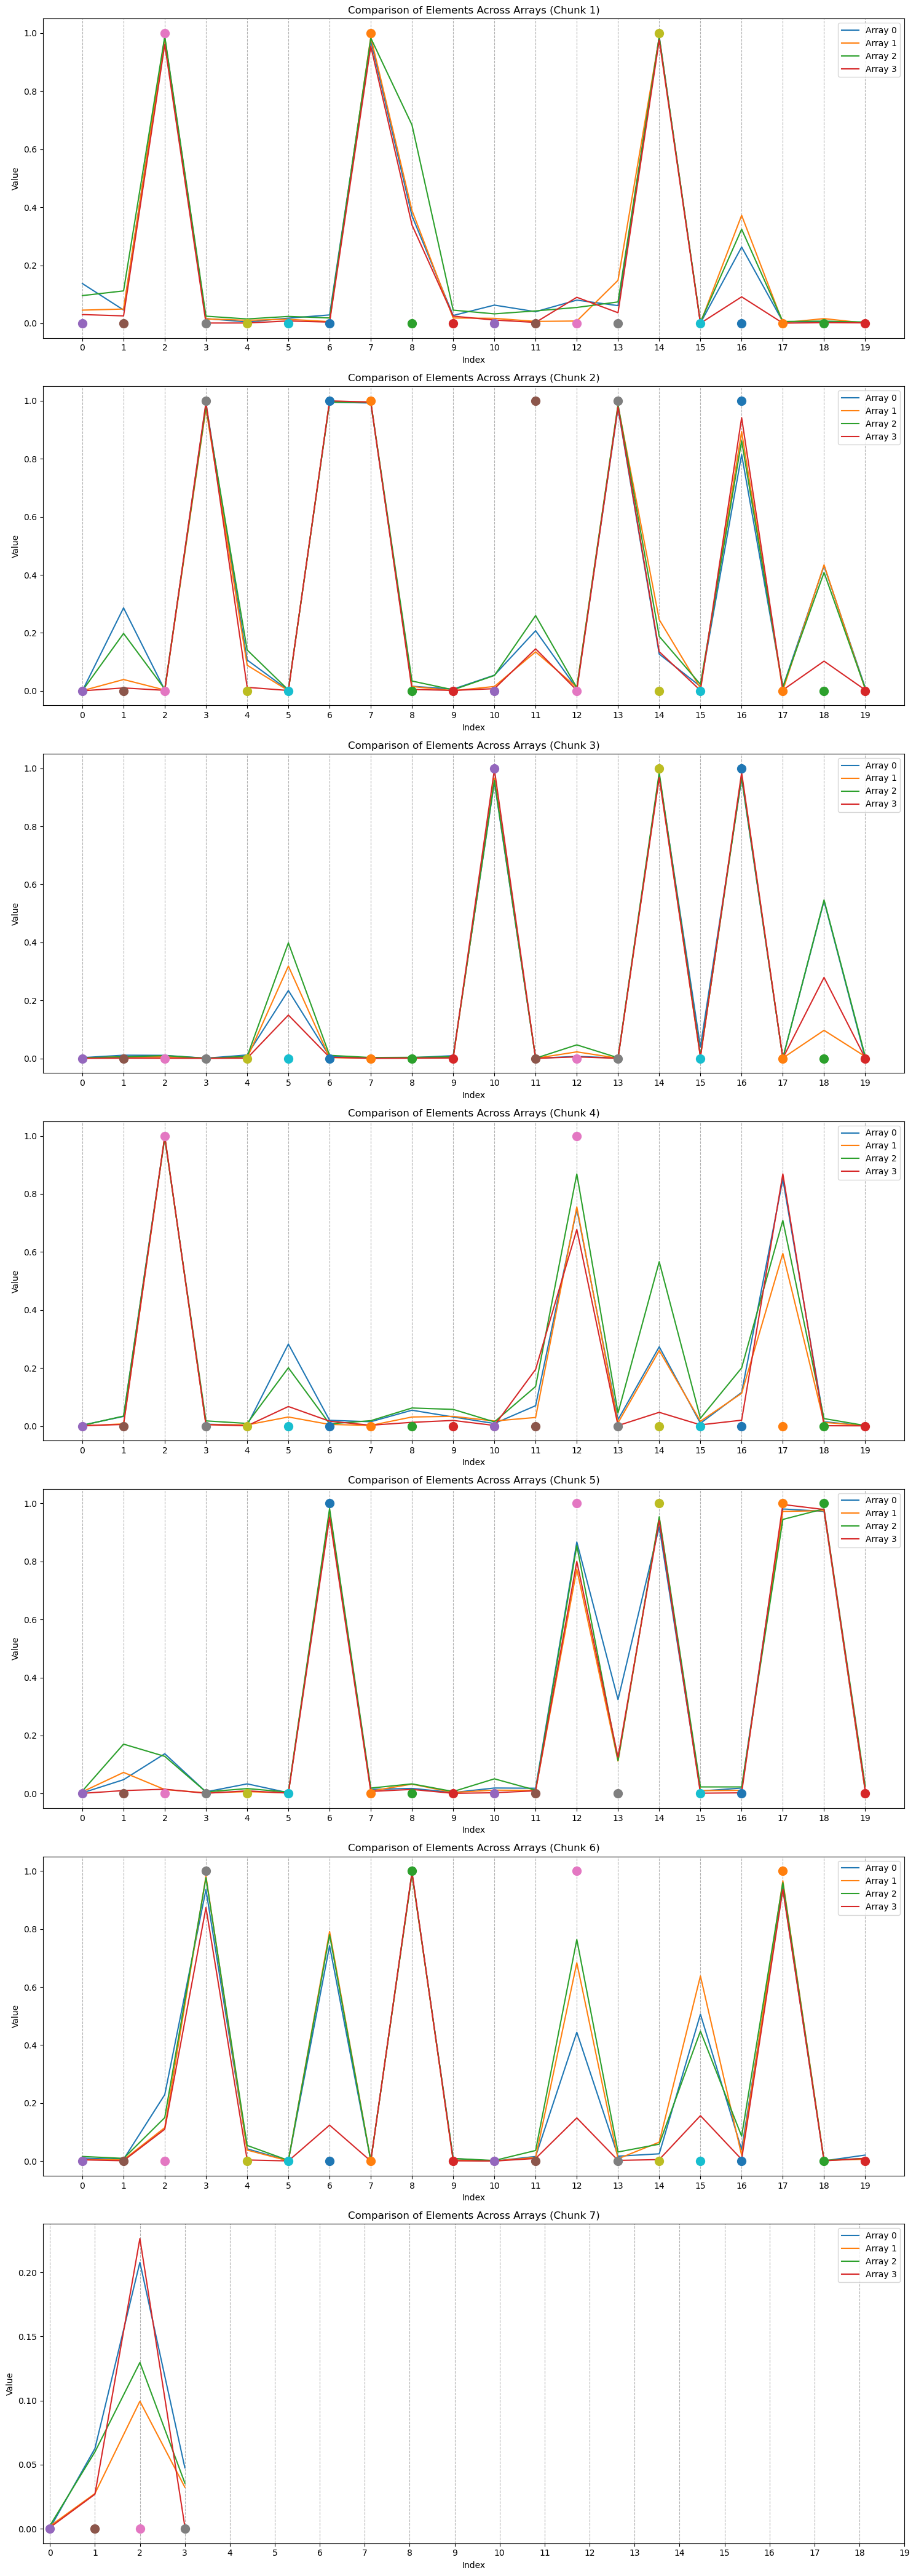

Log Loss xgb_02: 0.12807793578165472
Log Loss cat_01: 0.11310480240001629
Log Loss cat_02: 0.10958798189315433
Log Loss lgt_01: 0.13448726190087054
Log Loss avg: 0.11356237895754474
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00186146	valid_1's binary_logloss: 0.0809972


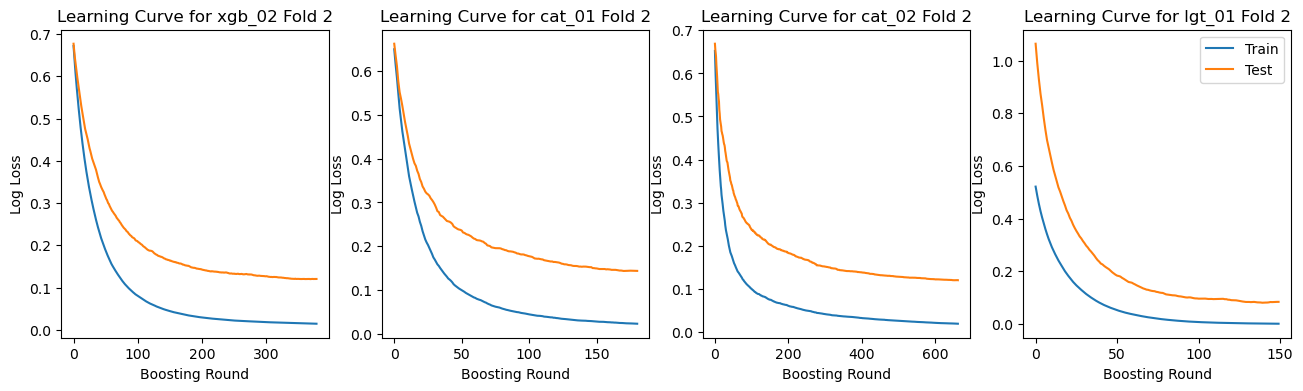

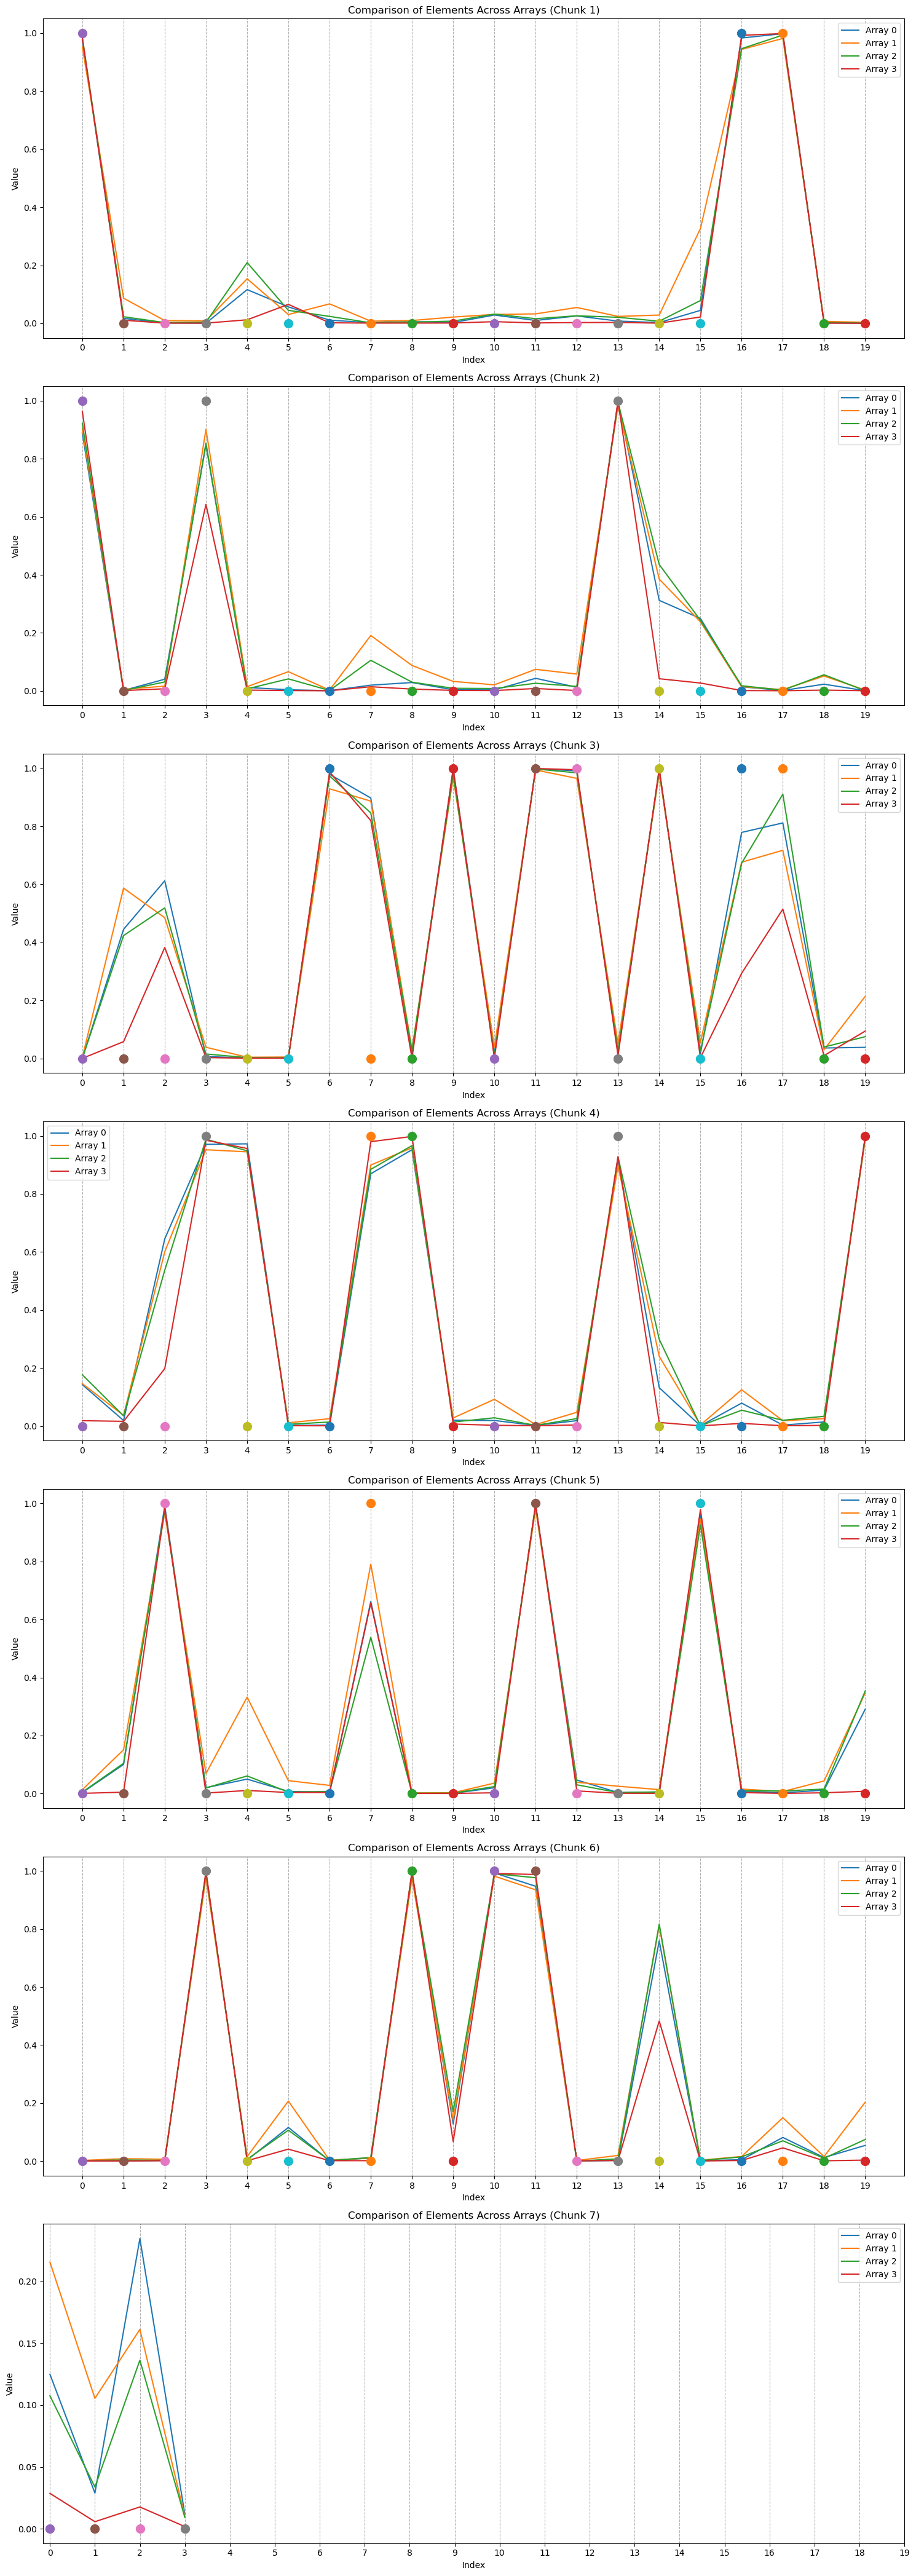

Log Loss xgb_02: 0.0997701115915079
Log Loss cat_01: 0.11961319054568895
Log Loss cat_02: 0.1027220497847089
Log Loss lgt_01: 0.09387042235173525
Log Loss avg: 0.10120526713625533
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.00836063	valid_1's binary_logloss: 0.16011


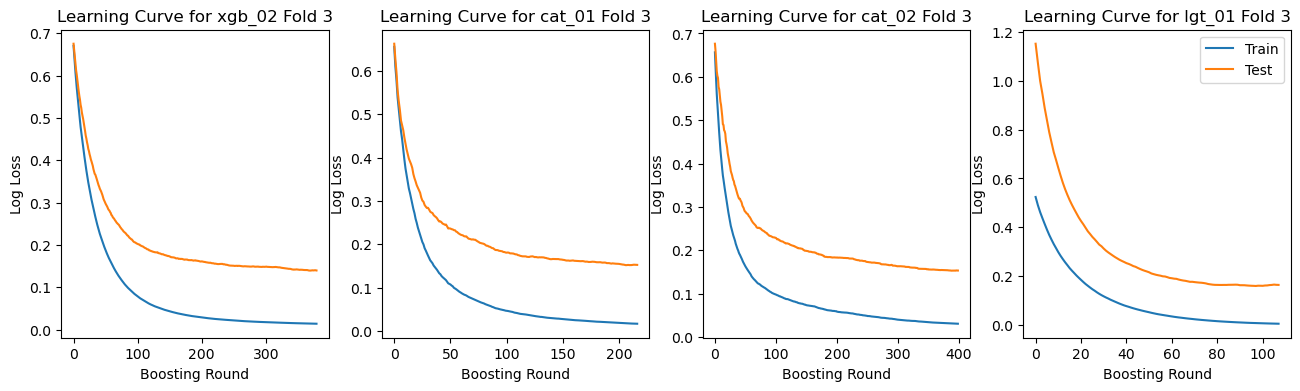

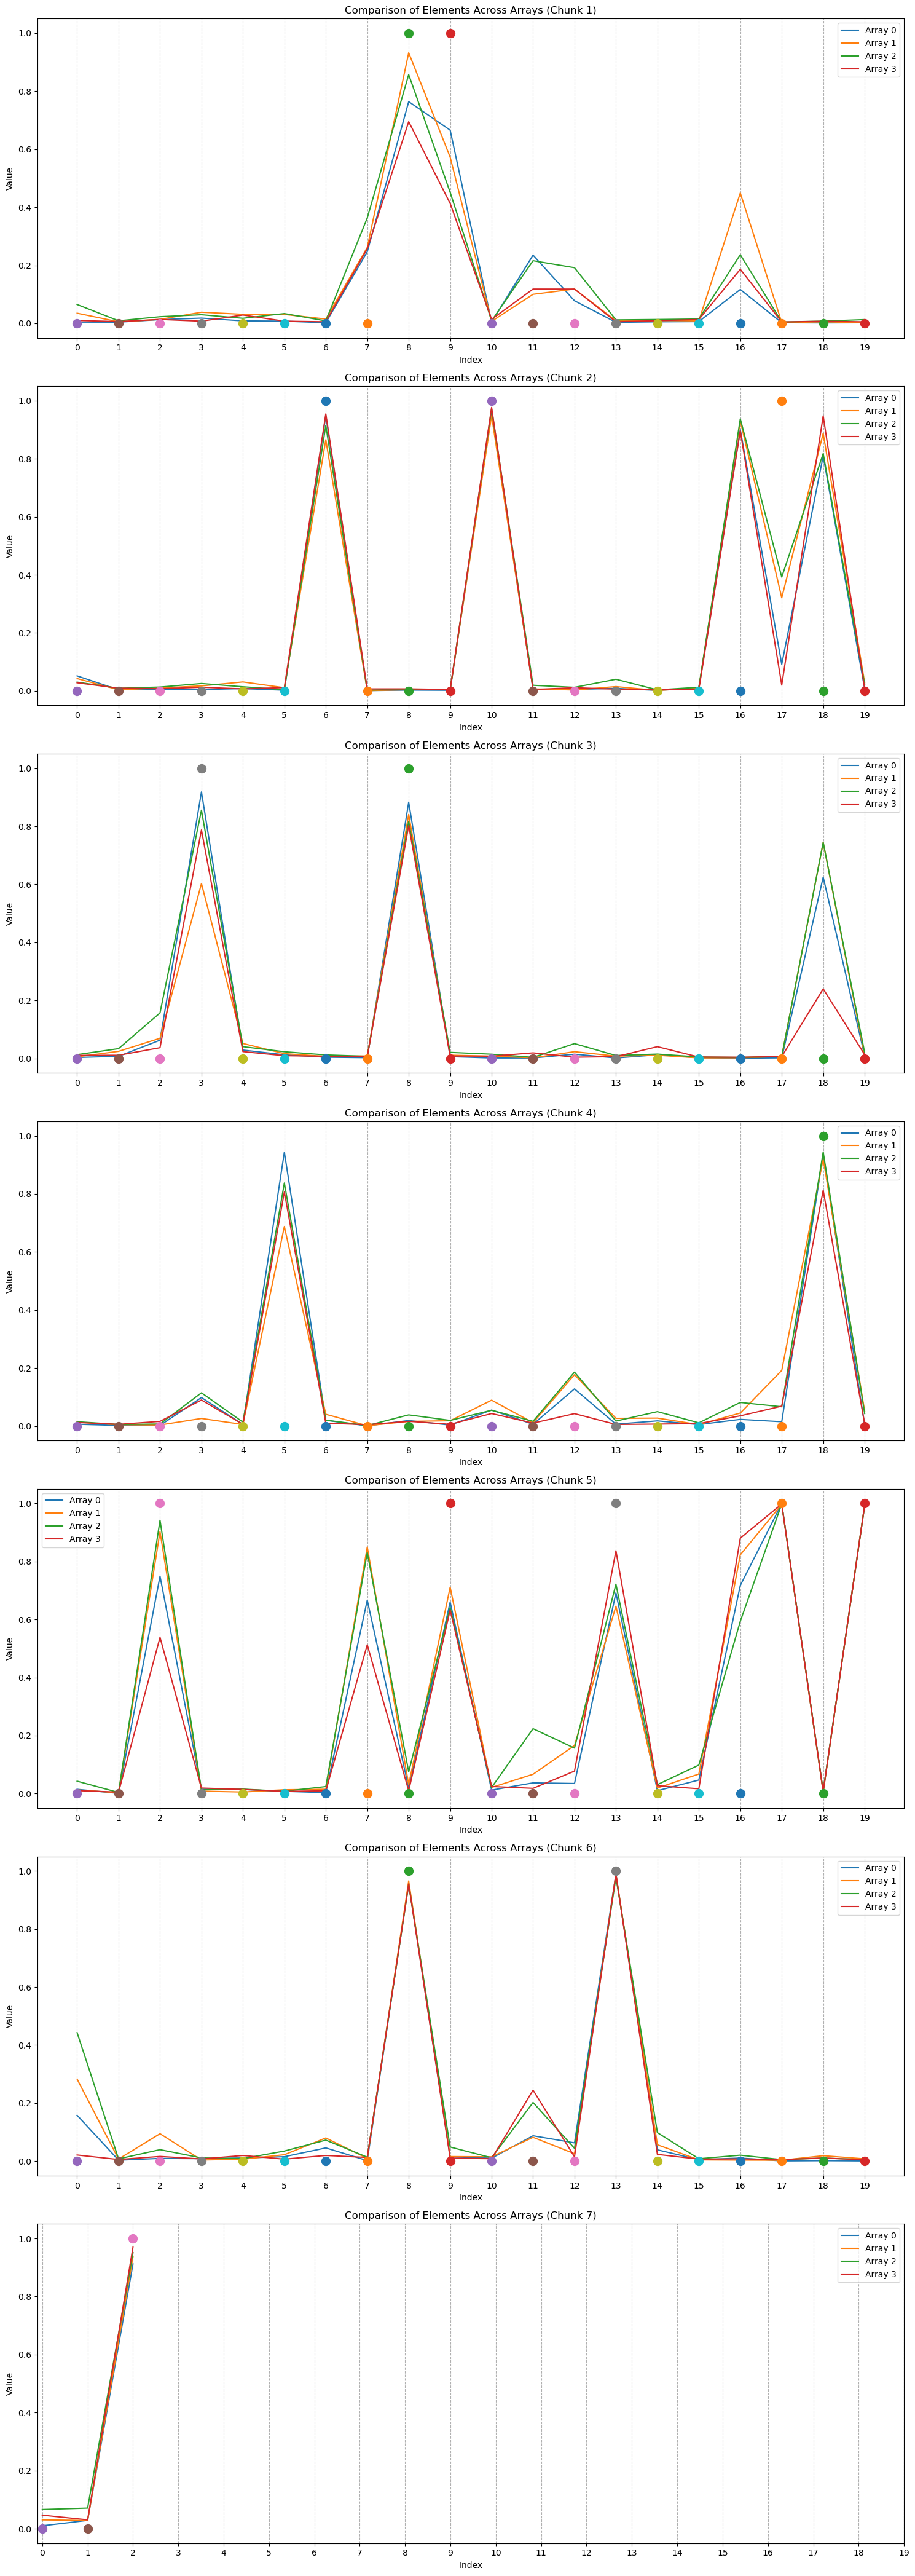

Log Loss xgb_02: 0.2040796368124895
Log Loss cat_01: 0.18616563689168975
Log Loss cat_02: 0.17771264547374113
Log Loss lgt_01: 0.2845039809243582
Log Loss avg: 0.17821525927298093
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00581331	valid_1's binary_logloss: 0.222878


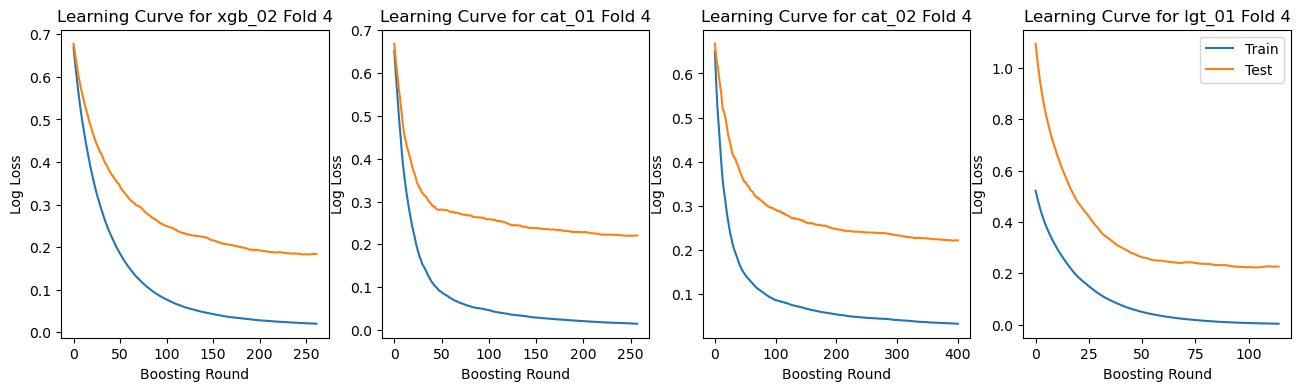

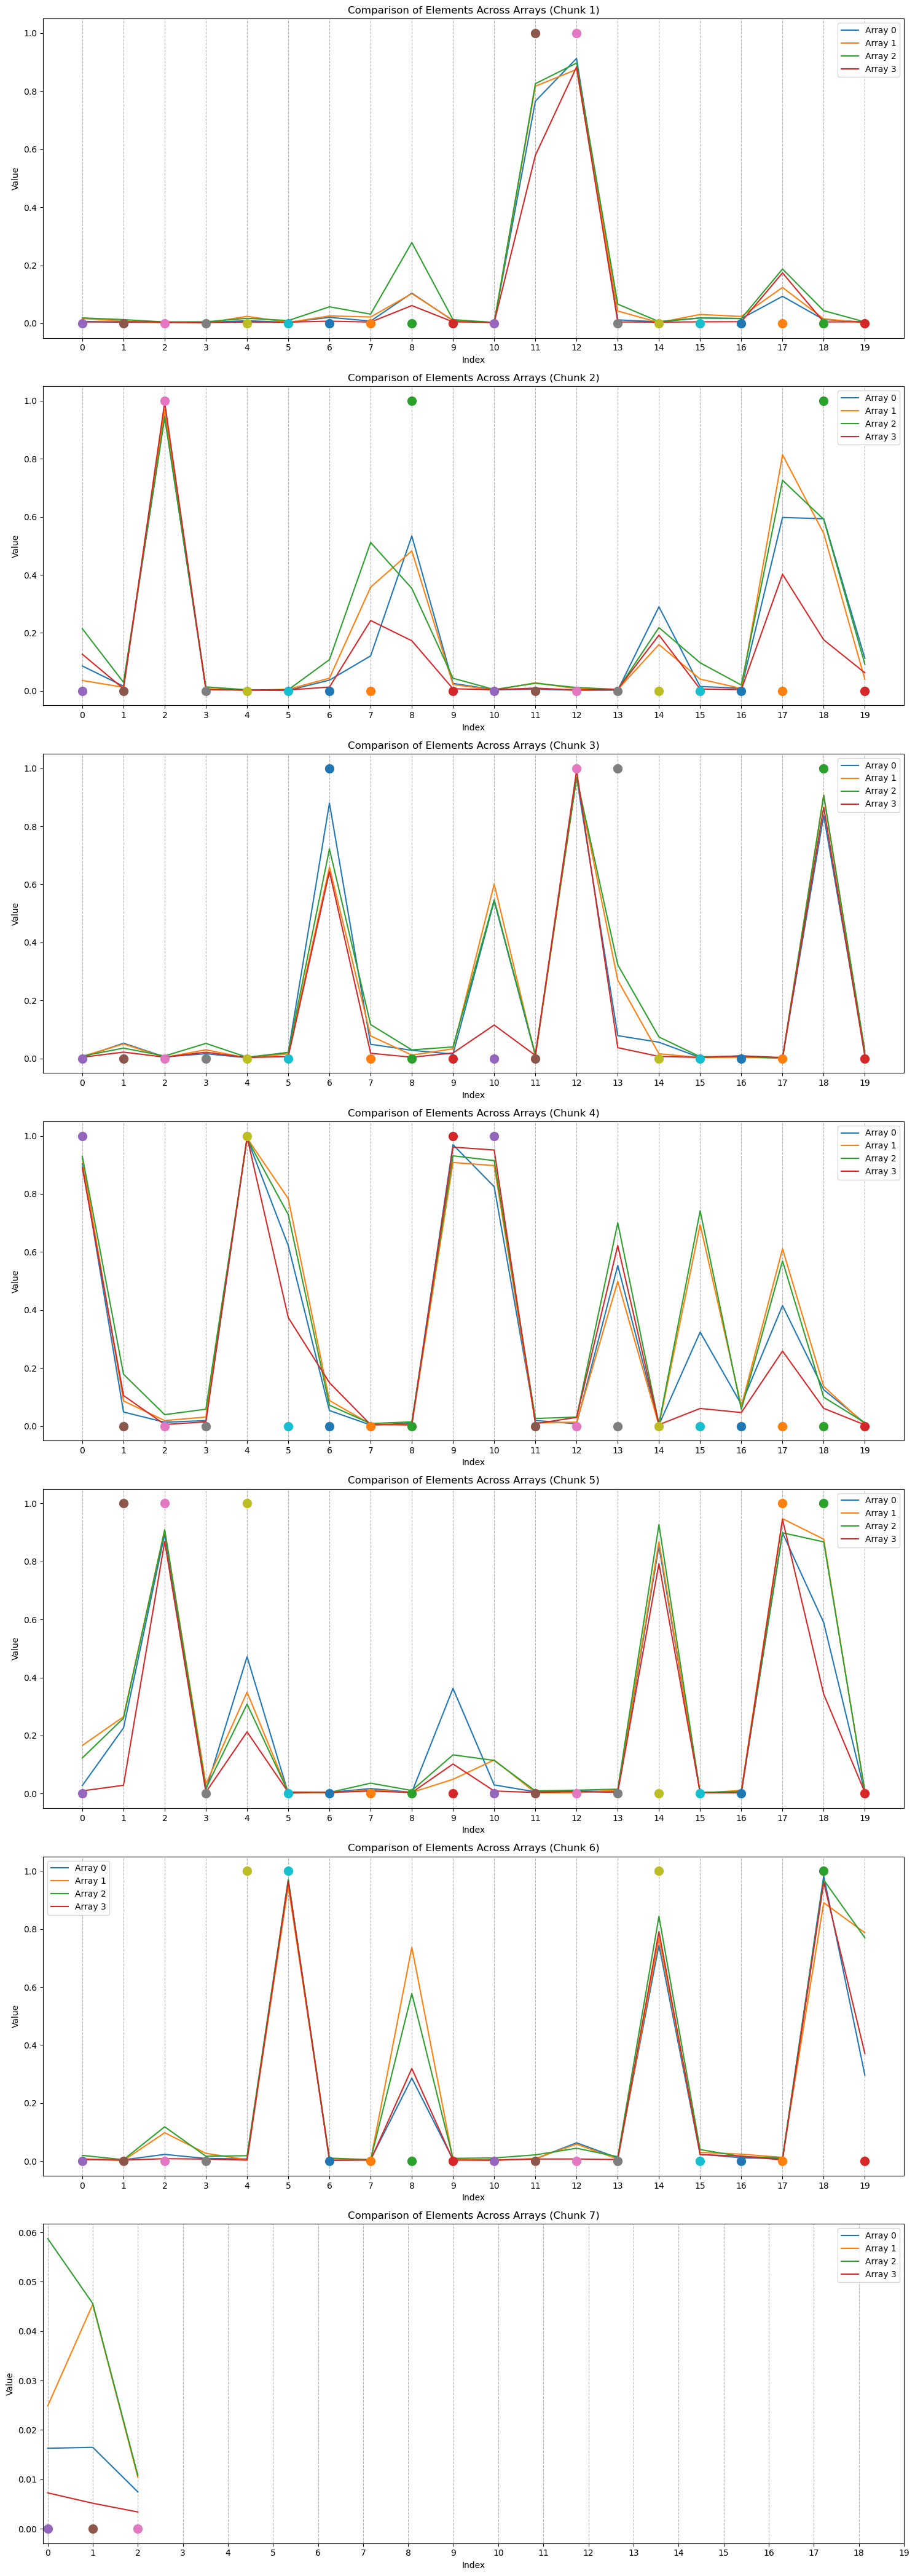

Log Loss xgb_02: 0.3421939614126629
Log Loss cat_01: 0.35049110524341065
Log Loss cat_02: 0.32731532101862953
Log Loss lgt_01: 0.501065634047004
Log Loss avg: 0.32269050694458906
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0112016	valid_1's binary_logloss: 0.166882


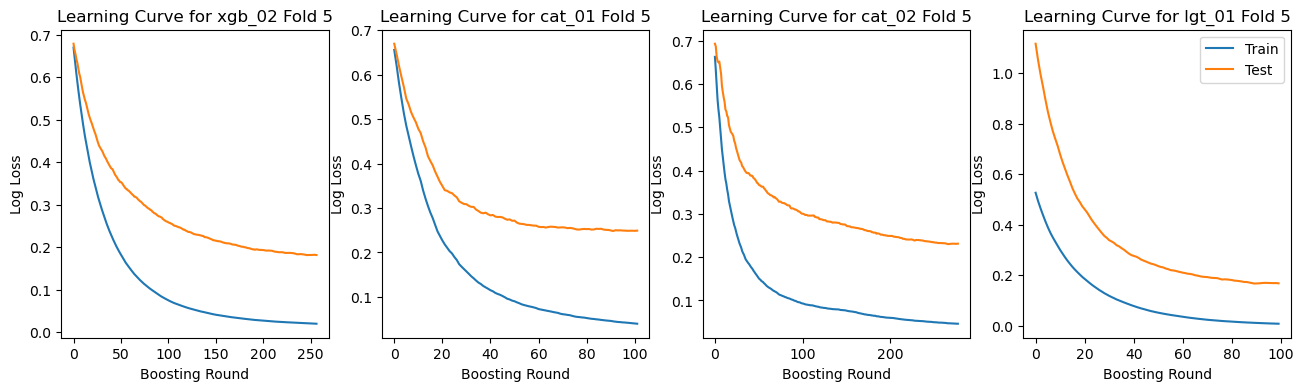

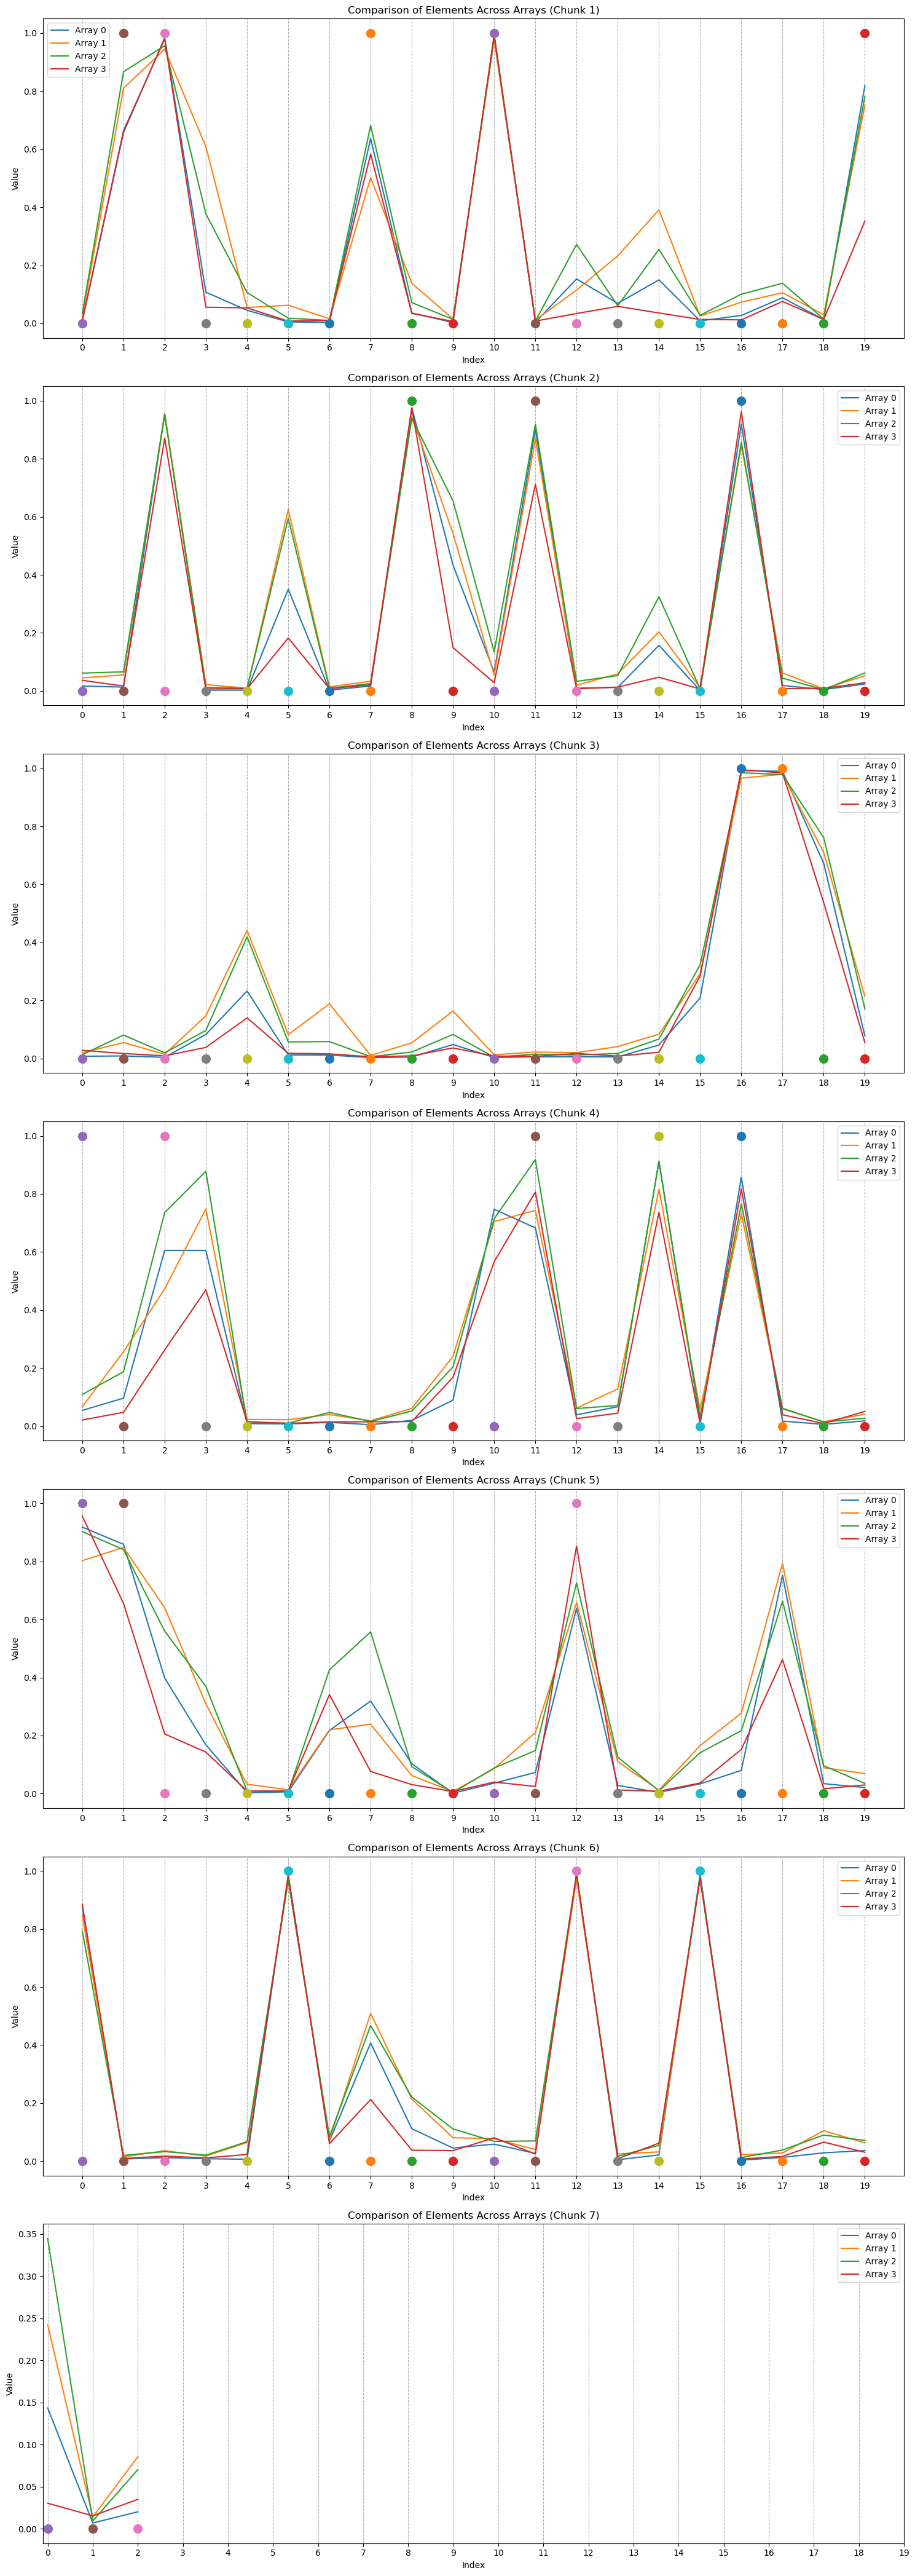

Log Loss xgb_02: 0.22481485757155695
Log Loss cat_01: 0.27891035646290674
Log Loss cat_02: 0.2294536509661456
Log Loss lgt_01: 0.2716074006290631
Log Loss avg: 0.2245309144190498
Total loss xgb_02: 0.9989365031698719
Total loss cat_01: 1.0482850915437123
Total loss cat_02: 0.9467916491363795
Total loss lgt_01: 1.2855346998530313
Total loss avg: 0.9402043267304199


In [24]:
X = create_feature(train_df)
y = train_df['Class']

# KFoldクロスバリデーション
kf = KFold(n_splits=5, shuffle=True, random_state=42)
test_X = create_feature(test_df)

append_time(X, test_X)

predictions = []

models = {
    # 'xgb_01': run_xgboost_01,
    'xgb_02': run_xgboost_02,
    'cat_01': run_catboost_01,
    'cat_02': run_catboost_02,
    # 'cat_03': run_catboost_03,
    'lgt_01': run_lightgbm_01,
    # 'lgt_02': run_lightgbm_02,
    # 'pfn_01': run_tabpfn_16,
}

sum_loss = [0.0] * (len(models)+1)
evaluations = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train_raw, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train_raw, y_val = y.iloc[train_index], y.iloc[val_index]

    ros = RandomOverSampler(random_state=42)
    # X_train, y_train = ros.fit_resample(X_train_raw, y_train_raw)
    X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Alpha'])
    y_train = (y_train != 'A').astype(int)
    # X_train, y_train = ros.fit_resample(X_train_raw, merged_df.iloc[train_index]['Gamma'])
    # y_train = (~(y_train.isin(['N', 'M']))).astype(int)

    X_train = X_train.drop(columns=['Class'])
    X_val = X_val.drop(columns=['Class'])

    cur_results = [func(X_train, y_train, X_val, y_val, test_X) for func in models.values()]

    # グラフの描画
    plt.figure(figsize=(20, 4))
    idx = 1
    for key, res in zip(models.keys(), cur_results):
        if res[2] is None:
            continue
        plt.subplot(1, 5, idx)
        if key.startswith('xgb'):
            plt.plot(res[2]['train']['logloss'], label='Train')
            plt.plot(res[2]['eval']['logloss'], label='Test')
        elif key.startswith('cat'):
            plt.plot(res[2]['learn']['Logloss'], label='Train')
            plt.plot(res[2]['validation']['Logloss'], label='Test')
        elif key.startswith('lgt'):
            plt.plot(res[2]['training']['binary_logloss'], label='Train')
            plt.plot(res[2]['valid_1']['binary_logloss'], label='Test')
        plt.xlabel('Boosting Round')
        plt.ylabel('Log Loss')
        plt.title(f'Learning Curve for {key} Fold {fold + 1}')
        idx += 1
    plt.legend()
    plt.show()

    cur_pred = [0.3*cur_results[0][1][i] + 0.7*cur_results[2][1][i] for i in range(len(cur_results[0][1]))]
    predictions.append(np.array(cur_pred))
    # for res in cur_results:
    #     predictions.append(res[1])

    evals = [res[0] for res in cur_results]
    # mean_evals = np.mean(evals, axis=0)
    mean_evals = [0.3*evals[0][i] + 0.7*evals[2][i] for i in range(len(evals[0]))]
    evals.append(mean_evals)
    evals.append(y_val.values)
    evals = np.array(evals)
    evaluations.append(evals)

    # 20要素ずつ分割して予測をプロット
    chunk_size = 20
    num_chunks = (len(evals[0]) + chunk_size - 1) // chunk_size

    fig, axs = plt.subplots(num_chunks, 1, figsize=(15, 6 * num_chunks))

    for chunk in range(num_chunks):
        for i in range(len(evals)-2):
            axs[chunk].plot(evals[i, chunk*chunk_size:min((chunk+1)*chunk_size, len(evals[0]))], label=f'Array {i}')
        for j in range(chunk_size):
            if chunk*chunk_size+j >= len(evals[-1]):
                break
            axs[chunk].plot(j, evals[-1][chunk*chunk_size+j], 'o', markersize=10)

        axs[chunk].set_xlabel('Index')
        axs[chunk].set_ylabel('Value')
        axs[chunk].set_xticks(np.arange(chunk_size))
        axs[chunk].grid(axis='x', linestyle='--')
        axs[chunk].set_title(f'Comparison of Elements Across Arrays (Chunk {chunk+1})')
        axs[chunk].legend()

    plt.tight_layout()
    plt.show()
    
    for idx, (key, one_eval) in enumerate(zip(list(models.keys()) + ['avg'], evals)):
        loss = balanced_log_loss(y_val, one_eval)
        print(f'Log Loss {key}: {loss}')
        sum_loss[idx] += loss

for key, loss in zip(list(models.keys()) + ['avg'], sum_loss):
    print(f"Total loss {key}: {loss}")

def run_optuna_wgt():
    def objective(trial):
        res = []
        for one_evals in evaluations:
            weight = [
                trial.suggest_float('w0', 0.001, 1.0),
                trial.suggest_float('w1', 0.001, 1.0),
                trial.suggest_float('w2', 0.001, 1.0),
                trial.suggest_float('w3', 0.001, 1.0),
            ]
            sum_weight = sum(weight)
            avg = [sum([one_evals[j][i] * weight[j] for j in range(4)])/sum_weight for i in range(len(one_evals[0]))]
            expected = [1 if v > 0.5 else 0 for v in one_evals[-1]]
            res.append(balanced_log_loss(expected, avg))

        return sum(res)

    study = optuna.create_study(study_name='wgt-study',
                                storage='sqlite:///wgt_study_alpha.db',
                                load_if_exists=True,
                                direction='minimize')
    study.optimize(objective, n_trials=1000, timeout=36000)

# run_optuna_wgt()
    
    
# 平均予測の計算
avg_prediction = np.mean(predictions, axis=0)
sum1 = avg_prediction.sum()
sum0 = len(avg_prediction) - sum1
final_prediction = np.array([p/sum1 / (p/sum1 + (1-p)/sum0) for p in avg_prediction])

# 出力DataFrameの作成
output = pd.DataFrame({
    'Id': test_df['Id'],
    'class_0': 1 - final_prediction,
    'class_1': final_prediction
})
# 結果をCSVファイルに保存
output.to_csv('submission.csv', index=False)

In [25]:
pd.read_csv('submission.csv')

Id  class_0  class_1
0  00eed32682bb      0.5      0.5
1  010ebe33f668      0.5      0.5
2  02fa521e1838      0.5      0.5
3  040e15f562a2      0.5      0.5
4  046e85c7cc7f      0.5      0.5